# Introduction

This notebook will be used only to plot data from the execution of Leaflet Finder with 131K atoms on SuperMic. The experiment setup is as follows:

1. Execution was done on Wrangler.
2. The core count was 64,256 cores
3. 1024 task in total, because of memory issues
4. The calculation was done over 131072,262144 and 524288 atoms.
5. Every task calculates the distances of the atoms it is assigned and returns an edje list. (Memory requirements of the 262K and 524K are 64 and 256GB respectivelly.
6. The produced list was aggregated to a single Unit to calculate the connected components.
7. In case of Spark implementations all three approaches were done

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas as pd
import radical.pilot as rp
import radical.analytics as ra
import radical.utils as ru
import glob
import os
import bokeh.plotting as bplt
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.layouts import gridplot,row,column
from bokeh.io import output_notebook
#from util.DaskProfileReader import *
from bokeh.charts import BoxPlot,Bar,Line,TimeSeries
from bokeh.models import Range1d, FixedTicker
from bokeh.models import CheckboxGroup, CustomJS

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Greens_r'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
output_notebook()

/Users/iparask/anaconda/envs/radical.analytics/lib/python2.7/site-packages/radical/utils/atfork/stdlib_fixer.py:63: UserWarning: logging module already imported before fixup.
  warnings.warn('logging module already imported before fixup.')
/Users/iparask/anaconda/envs/radical.analytics/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Loading BokehJS ...

In [2]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [3]:
def SparkLogToDataFrame(path,filename):
    import json
    import pandas
    import numpy as np

    columns=['StageID','TaskId','ExecutorID','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','GettingResultTime','ResultSerializationTime','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

      
        
        
    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((1,11),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0,0] = int(stat['Stage ID'])
            data_point[0,1] = int(stat['Task Info']['Task ID'])
            data_point[0,2] = int(stat['Task Info']['Executor ID'])
            data_point[0,3] = int(stat['Task Info']['Launch Time'])
            data_point[0,5] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[0,6] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[0,7] = int(stat['Task Info']['Finish Time'])-int(stat['Task Info']['Getting Result Time']) if int(stat['Task Info']['Getting Result Time'])!=0 else 0 
            data_point[0,8] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[0,9] = int(stat['Task Info']['Finish Time'])
            data_point[0,10] = int(stat['Task Metrics']['Result Size'])
            
            data_point[0,4]= data_point[0,9]-data_point[0,3]-data_point[0,5]-data_point[0,6]-data_point[0,8]-data_point[0,7]
            data_case = pandas.DataFrame(data_point,columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [4]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/' + appName
        print appPath
        timings = np.load(path + sessionName + '/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [5]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

In [6]:
import ast
from bokeh.palettes import viridis
from toolz import valmap, merge, memoize
import random
import itertools
import pandas as pd



task_stream_palette = list(viridis(25))
random.shuffle(task_stream_palette)

counter = itertools.count()

_incrementing_index_cache = dict()


@memoize(cache=_incrementing_index_cache)
def incrementing_index(o):
    return next(counter)


def color_of(o, palette=task_stream_palette):
    return palette[incrementing_index(o) % len(palette)]

def color_of_message(key):
        return color_of(key)

colors = {'transfer': 'red',
          'disk-write': 'orange',
          'disk-read': 'orange',
          'deserialize': 'gray',
          'compute': color_of_message}


alphas = {'transfer': 0.4,
          'compute': 1,
          'deserialize': 0.4,
          'disk-write': 0.4,
          'disk-read': 0.4}


prefix = {'transfer': 'transfer-',
          'disk-write': 'disk-write-',
          'disk-read': 'disk-read-',
          'deserialize': 'deserialize-',
          'compute': ''}


def key_split(s):
    
    if type(s) is bytes:
        s = s.decode()
    if type(s) is tuple:
        s = s[0]
    try:
        words = s.split('-')
        if not words[0][0].isalpha():
            result = words[0].lstrip("'(\"")
        else:
            result = words[0]
        for word in words[1:]:
            if word.isalpha() and not (len(word) == 8 and
                                       hex_pattern.match(word) is not None):
                result += '-' + word
            else:
                break
        if len(result) == 32 and re.match(r'[a-f0-9]{32}', result):
            return 'data'
        else:
            if result[0] == '<':
                result = result.strip('<>').split()[0].split('.')[-1]
            return result
    except:
        return 'Other'



def DaskProfileReader(filename):

    profFile = open(filename)
    profiles = profFile.readlines()
    buffer = [ast.literal_eval(x) for x in profiles]
    workIds = {}
    id = 1


    L_start = list()
    L_stop = list()
    L_duration = list()
    L_key = list()
    L_action = list()
    L_name = list()
    L_y = list()

    for msg in buffer:
        key = msg[0]
        name = key_split(key)
        startstops = msg[-1]
        if not workIds.has_key(msg[3]):
            workIds[msg[3]]=id
            id+=1

        for action, start, stop in startstops:
            L_start.append(start)
            L_stop.append(stop)
            L_duration.append(stop - start)
            L_key.append(key)
            L_action.append(action)
            L_name.append(name)
            L_y.append(workIds[msg[3]])


    return pd.DataFrame.from_dict({'start': L_start,
            'stop': L_stop,
            'duration': L_duration,
            'key': L_key,
            'name': L_name,
            'action':L_action,
            'y': L_y})



## RADICAL-Pilot

In [7]:
json_files = glob.glob('Vanilla/Wrangler/v0.46/*_64_*/*_64_*.json')
sessions64=dict()
for json_file in json_files:
    src = ''.join([x+'/' for x in json_file.split('/')[0:-1]])
    json      = ru.read_json(json_file)
    sid       = os.path.basename(json_file)[:-5]
    sessions64[sid] = ra.Session(sid, 'radical.pilot', src=src)
    
json_files = glob.glob('Vanilla/Wrangler/v0.46/*_256_*/*_256_*.json')
sessions256=dict()
for json_file in json_files:
    src = ''.join([x+'/' for x in json_file.split('/')[0:-1]])
    json      = ru.read_json(json_file)
    sid       = os.path.basename(json_file)[:-5]
    sessions256[sid] = ra.Session(sid, 'radical.pilot', src=src)

In [8]:
RPexpsW = pd.DataFrame(columns=['Atoms','Cores','Run','RADICAL-Pilot Overhead','RADICAL-Pilot Edge Disc','RADICAL-Pilot DataMovement','RADICAL-Pilot ConnComp'])

for sid,session in sessions64.iteritems():
    uid=list()
    for i in range(1,1025):
        uid.append('unit.%06d'%i)
    units = session.filter(uid=uid,etype='unit',inplace=False)
    pilot = session.filter(etype='pilot',inplace=False)
    compUnit = session.filter(uid='unit.001025',etype='unit',inplace=False)
    overhead = np.min(units.timestamps(state=rp.AGENT_EXECUTING)) - pilot.timestamps(state=[rp.PMGR_ACTIVE])
    execution_time = np.max(units.timestamps(state=rp.AGENT_STAGING_OUTPUT_PENDING)) - np.min(units.timestamps(state=rp.AGENT_EXECUTING))
    data_movement = compUnit.timestamps(state=rp.AGENT_EXECUTING) - np.max(units.timestamps(state=rp.AGENT_STAGING_OUTPUT_PENDING))
    connComp = compUnit.timestamps(state=rp.AGENT_STAGING_OUTPUT_PENDING)[0] - compUnit.timestamps(state=rp.AGENT_EXECUTING)[0]
    cores = 64
    run = int(sid.split('_')[-1])
    atoms = int((sid.split('_')[1]).split('K')[0])
    RPexpsW.loc[len(RPexpsW)] = [atoms,cores,run,overhead,execution_time,data_movement,connComp]

for sid,session in sessions256.iteritems():
    uid=list()
    for i in range(1,1025):
        uid.append('unit.%06d'%i)
    units = session.filter(uid=uid,etype='unit',inplace=False)
    pilot = session.filter(etype='pilot',inplace=False)
    compUnit = session.filter(uid='unit.001025',etype='unit',inplace=False)
    overhead = np.min(units.timestamps(state=rp.AGENT_EXECUTING)) - pilot.timestamps(state=[rp.PMGR_ACTIVE])
    execution_time = np.max(units.timestamps(state=rp.AGENT_STAGING_OUTPUT_PENDING)) - np.min(units.timestamps(state=rp.AGENT_EXECUTING))
    data_movement = compUnit.timestamps(state=rp.AGENT_EXECUTING) - np.max(units.timestamps(state=rp.AGENT_STAGING_OUTPUT_PENDING))
    connComp = compUnit.timestamps(state=rp.AGENT_STAGING_OUTPUT_PENDING)[0] - compUnit.timestamps(state=rp.AGENT_EXECUTING)[0]
    cores = 256
    run = int(sid.split('_')[-1])
    atoms = int((sid.split('_')[1]).split('K')[0])
    RPexpsW.loc[len(RPexpsW)] = [atoms,cores,run,overhead,execution_time,data_movement,connComp]

In [9]:
RPexpsW.sort_values(['Atoms','Cores','Run'],inplace=True)
RPexpsW.reset_index(drop=True)
RPmeansW = pd.DataFrame(columns=['Atoms','Cores','Run','RADICAL-Pilot Overhead','RADICAL-Pilot Edge Disc','RADICAL-Pilot DataMovement','RADICAL-Pilot ConnComp'])
RPmeansW.loc[1] = RPexpsW[0:3].mean().values
RPmeansW.loc[2] = RPexpsW[3:6].mean().values
RPmeansW.loc[3] = RPexpsW[6:9].mean().values
RPmeansW.loc[4] = RPexpsW[9:12].mean().values
RPmeansW.loc[5] = RPexpsW[12:15].mean().values
RPmeansW.loc[6] = RPexpsW[15:18].mean().values
RPmeansW = RPmeansW.drop('Run',1)
RPmeansW = RPmeansW.drop('Atoms',1)

# 1. Broadcast Experiments

## 1.1 Setting up everything

In [10]:
spWrangler = pd.DataFrame.from_csv('Spark/Wrangler/Wrangler.csv')

SpWraBroad = spWrangler[spWrangler['Style']=='Br']
SpWraCollect = spWrangler[spWrangler['Style']=='Col']
SpWraPcc = spWrangler[spWrangler['Style']=='Pcc']

SpWraBroad131=SpWraBroad[SpWraBroad['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraBroad262=SpWraBroad[SpWraBroad['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraBroad524=SpWraBroad[SpWraBroad['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpWraColl131=SpWraCollect[SpWraCollect['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraColl262=SpWraCollect[SpWraCollect['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraColl524=SpWraCollect[SpWraCollect['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)

SpWraPcc131=SpWraPcc[SpWraPcc['Atom']==131].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraPcc262=SpWraPcc[SpWraPcc['Atom']==262].drop(['SessionName','JsonName','Style','Atom','Run'],1)
SpWraPcc524=SpWraPcc[SpWraPcc['Atom']==524].drop(['SessionName','JsonName','Style','Atom','Run'],1)


In [11]:
SpWraBroad131['TotalOverhead']=SpWraBroad131['Overhead']+SpWraBroad131['DataInit']
SpWraBroad131 = SpWraBroad131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraBroad262['TotalOverhead']=SpWraBroad262['Overhead']+SpWraBroad262['DataInit']
SpWraBroad262 = SpWraBroad262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraBroad524['TotalOverhead']=SpWraBroad524['Overhead']+SpWraBroad524['DataInit']
SpWraBroad524 = SpWraBroad524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraColl131['TotalOverhead']=SpWraColl131['Overhead']+SpWraColl131['DataInit']
SpWraColl131 = SpWraColl131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraColl262['TotalOverhead']=SpWraColl262['Overhead']+SpWraColl262['DataInit']
SpWraColl262 = SpWraColl262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraColl524['TotalOverhead']=SpWraColl524['Overhead']+SpWraColl524['DataInit']
SpWraColl524 = SpWraColl524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraPcc131['TotalOverhead']=SpWraPcc131['Overhead']+SpWraPcc131['DataInit']
SpWraPcc131 = SpWraPcc131.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraPcc262['TotalOverhead']=SpWraPcc262['Overhead']+SpWraPcc262['DataInit']
SpWraPcc262 = SpWraPcc262.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

SpWraPcc524['TotalOverhead']=SpWraPcc524['Overhead']+SpWraPcc524['DataInit']
SpWraPcc524 = SpWraPcc524.drop(['Overhead','DataInit'],axis=1)[['Cores','TotalOverhead','AdjList','ConnComp','TotalTime']]

In [12]:
SpWraBroad131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])
SpWraBroad262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])
SpWraBroad524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 1','Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1','Pilot-Spark TotalTime Approach 1'])

SpWraColl131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])
SpWraColl262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])
SpWraColl524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 2','Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2','Pilot-Spark TotalTime Approach 2'])

SpWraPcc131mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])
SpWraPcc262mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])
SpWraPcc524mean = pd.DataFrame(columns=['Cores','Pilot-Spark Overhead Approach 3','Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3','Pilot-Spark TotalTime Approach 3'])


for i in range(0,9,3):
    SpWraBroad131mean.loc[len(SpWraBroad131mean)] = SpWraBroad131[i:i+3].mean().values
    SpWraBroad262mean.loc[len(SpWraBroad262mean)] = SpWraBroad262[i:i+3].mean().values
    SpWraBroad524mean.loc[len(SpWraBroad524mean)] = SpWraBroad524[i:i+3].mean().values
    SpWraColl131mean.loc[len(SpWraColl131mean)] = SpWraColl131[i:i+3].mean().values
    SpWraColl262mean.loc[len(SpWraColl262mean)] = SpWraColl262[i:i+3].mean().values
    SpWraColl524mean.loc[len(SpWraColl524mean)] = SpWraColl524[i:i+3].mean().values
    SpWraPcc131mean.loc[len(SpWraPcc131mean)] = SpWraPcc131[i:i+3].mean().values
    SpWraPcc262mean.loc[len(SpWraPcc262mean)] = SpWraPcc262[i:i+3].mean().values
    SpWraPcc524mean.loc[len(SpWraPcc524mean)] = SpWraPcc524[i:i+3].mean().values

In [13]:
DaWrangler = pd.DataFrame.from_csv('Dask/Wrangler/Wrangler.csv')
DaWraBroad = DaWrangler[DaWrangler['Style']=='Br'].reset_index()
DaWraCollect = DaWrangler[DaWrangler['Style']=='Col'].reset_index()
DaWraParCC = DaWrangler[DaWrangler['Style']=='ParCC'].reset_index()



In [14]:
DaWraBroad['TaskExec']=0
for json in DaWraBroad['JsonName']:
    Profile = DaskProfileReader('Dask/Wrangler/Broadcast/iteration1/'+json)
    ActualExecutionTime = (Profile['start']+Profile['duration']).max() - Profile['start'].min()
    DaWraBroad['TaskExec'][DaWraBroad['JsonName']==json] = ActualExecutionTime

DaWraBroad = DaWraBroad.drop('index',1)

/Users/iparask/anaconda/envs/radical.analytics/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
DaWraParCC['TaskExec']=0
for json in DaWraCollect['JsonName']:
    Profile = DaskProfileReader('Dask/Wrangler/ParCC/'+json)
    ActualExecutionTime = (Profile['start']+Profile['duration']).max() - Profile['start'].min()
    DaWraParCC['TaskExec'][DaWraParCC['JsonName']==json] = ActualExecutionTime

DaWraParCC = DaWraParCC.drop('index',1)

/Users/iparask/anaconda/envs/radical.analytics/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [16]:
DaWraCollect['TaskExec']=0
for json in DaWraCollect['JsonName']:
    Profile = DaskProfileReader('Dask/Wrangler/Collect/'+json)
    ActualExecutionTime = (Profile['start']+Profile['duration']).max() - Profile['start'].min()
    DaWraCollect['TaskExec'][DaWraCollect['JsonName']==json] = ActualExecutionTime

DaWraCollect = DaWraCollect.drop('index',1)

/Users/iparask/anaconda/envs/radical.analytics/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [17]:
DaWraBroad131E=DaWraBroad[DaWraBroad['Atom']==131].drop(['JsonName','Style','Atom','Run','Write','DataInit','ConnComp','TotalTime'],1)
DaWraBroad131E['TaskExec'] = DaWraBroad131E['TaskExec']
DaWraBroad131E['AdjList']=DaWraBroad131E['AdjList'] - DaWraBroad131E['TaskExec']

In [18]:
DaWraBroad131E=DaWraBroad[DaWraBroad['Atom']==131].drop(['JsonName','Style','Atom','Run','Write','DataInit','ConnComp','TotalTime'],1)
DaWraBroad131E['TaskExec'] = DaWraBroad131E['TaskExec']
DaWraBroad131E['AdjList']=DaWraBroad131E['AdjList'] - DaWraBroad131E['TaskExec']
DaWraBroad262E=DaWraBroad[DaWraBroad['Atom']==262].drop(['JsonName','Style','Atom','Run','Write','DataInit','ConnComp','TotalTime'],1)
DaWraBroad262E['TaskExec'] = DaWraBroad262E['TaskExec']
DaWraBroad262E['AdjList']=DaWraBroad262E['AdjList'] - DaWraBroad262E['TaskExec']

DaWraColl131E=DaWraCollect[DaWraCollect['Atom']==131].drop(['JsonName','Style','Atom','Run','Write','DataInit','ConnComp','TotalTime'],1)
DaWraColl131E['TaskExec'] = DaWraColl131E['TaskExec']
DaWraColl131E['AdjList']=DaWraColl131E['AdjList'] - DaWraColl131E['TaskExec']
DaWraColl262E=DaWraCollect[DaWraCollect['Atom']==262].drop(['JsonName','Style','Atom','Run','Write','DataInit','ConnComp','TotalTime'],1)
DaWraColl262E['TaskExec'] = DaWraColl262E['TaskExec']
DaWraColl262E['AdjList']=DaWraColl262E['AdjList'] - DaWraColl262E['TaskExec']
DaWraColl524E=DaWraCollect[DaWraCollect['Atom']==524].drop(['JsonName','Style','Atom','Run','Write','DataInit','ConnComp','TotalTime'],1)
DaWraColl524E['TaskExec'] = DaWraColl524E['TaskExec']
DaWraColl524E['AdjList']=DaWraColl524E['AdjList'] - DaWraColl524E['TaskExec']

DaWraBroad131Emean = pd.DataFrame(columns=['Cores','Dask Adj Overhead Approach 1','Dask Adj Execution Approach 1'])
DaWraBroad262Emean = pd.DataFrame(columns=['Cores','Dask Adj Overhead Approach 1','Dask Adj Execution Approach 1'])

DaWraColl131Emean = pd.DataFrame(columns=['Cores','Dask Adj Overhead Approach 2','Dask Adj Execution Approach 2'])
DaWraColl262Emean = pd.DataFrame(columns=['Cores','Dask Adj Overhead Approach 2','Dask Adj Execution Approach 2'])
DaWraColl524Emean = pd.DataFrame(columns=['Cores','Dask Adj Overhead Approach 2','Dask Adj Execution Approach 2'])

DaWraBroad131Emean.loc[0] = DaWraBroad131E[0:3].mean().values
DaWraBroad131Emean.loc[1] = DaWraBroad131E[3:6].mean().values

DaWraBroad262Emean.loc[0] = DaWraBroad262E[0:3].mean().values
DaWraBroad262Emean.loc[1] = DaWraBroad262E[3:6].mean().values

DaWraColl131Emean.loc[0] = DaWraColl131E[0:3].mean().values
DaWraColl131Emean.loc[1] = DaWraColl131E[3:6].mean().values

DaWraColl262Emean.loc[0] = DaWraColl262E[0:3].mean().values
DaWraColl262Emean.loc[1] = DaWraColl262E[3:6].mean().values

DaWraColl524Emean.loc[0] = DaWraColl524E[0:3].mean().values
DaWraColl524Emean.loc[1] = DaWraColl524E[3:6].mean().values

In [19]:
DaWraBroad131E=DaWraBroad[DaWraBroad['Atom']==131].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)
DaWraBroad262E=DaWraBroad[DaWraBroad['Atom']==262].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)

DaWraColl131=DaWraCollect[DaWraCollect['Atom']==131].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)
DaWraColl262=DaWraCollect[DaWraCollect['Atom']==262].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)
DaWraColl524=DaWraCollect[DaWraCollect['Atom']==524].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)

DaWraParCC131=DaWraParCC[DaWraParCC['Atom']==131].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)
DaWraParCC262=DaWraParCC[DaWraParCC['Atom']==262].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)
DaWraParCC524=DaWraParCC[DaWraParCC['Atom']==524].drop(['JsonName','Style','Atom','Run','Write','TaskExec'],1)

DaWraBroad131mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 1','Dask Edge Disc Approach 1','Dask ConnComp Approach 1','Dask TotalTime Approach 1'])
DaWraBroad262mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 1','Dask Edge Disc Approach 1','Dask ConnComp Approach 1','Dask TotalTime Approach 1'])

DaWraColl131mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 2','Dask Edge Disc Approach 2','Dask ConnComp Approach 2','Dask TotalTime Approach 2'])
DaWraColl262mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 2','Dask Edge Disc Approach 2','Dask ConnComp Approach 2','Dask TotalTime Approach 2'])
DaWraColl524mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 2','Dask Edge Disc Approach 2','Dask ConnComp Approach 2','Dask TotalTime Approach 2'])

DaWraParCC131mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 3','Dask Partial CC Approach 3','Dask Join CC Approach 3','Dask TotalTime Approach 3'])
DaWraParCC262mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 3','Dask Partial CC Approach 3','Dask Join CC Approach 3','Dask TotalTime Approach 3'])
DaWraParCC524mean = pd.DataFrame(columns=['Cores','Dask Overhead Approach 3','Dask Partial CC Approach 3','Dask Join CC Approach 3','Dask TotalTime Approach 3'])

DaWraBroad131mean.loc[0] = DaWraBroad131E[0:3].mean().values
DaWraBroad131mean.loc[1] = DaWraBroad131E[3:6].mean().values

DaWraBroad262mean.loc[0] = DaWraBroad262E[0:3].mean().values
DaWraBroad262mean.loc[1] = DaWraBroad262E[3:6].mean().values

DaWraColl131mean.loc[0] = DaWraColl131[0:3].mean().values
DaWraColl131mean.loc[1] = DaWraColl131[3:6].mean().values

DaWraColl262mean.loc[0] = DaWraColl262[0:3].mean().values
DaWraColl262mean.loc[1] = DaWraColl262[3:6].mean().values

DaWraColl524mean.loc[0] = DaWraColl524[0:3].mean().values
DaWraColl524mean.loc[1] = DaWraColl524[3:6].mean().values

DaWraParCC131mean.loc[0] = DaWraParCC131[0:3].mean().values
DaWraParCC131mean.loc[1] = DaWraParCC131[3:6].mean().values

DaWraParCC262mean.loc[0] = DaWraParCC262[0:3].mean().values
DaWraParCC262mean.loc[1] = DaWraParCC262[3:6].mean().values

DaWraParCC524mean.loc[0] = DaWraParCC524[0:3].mean().values
DaWraParCC524mean.loc[1] = DaWraParCC524[3:6].mean().values

# Plotting

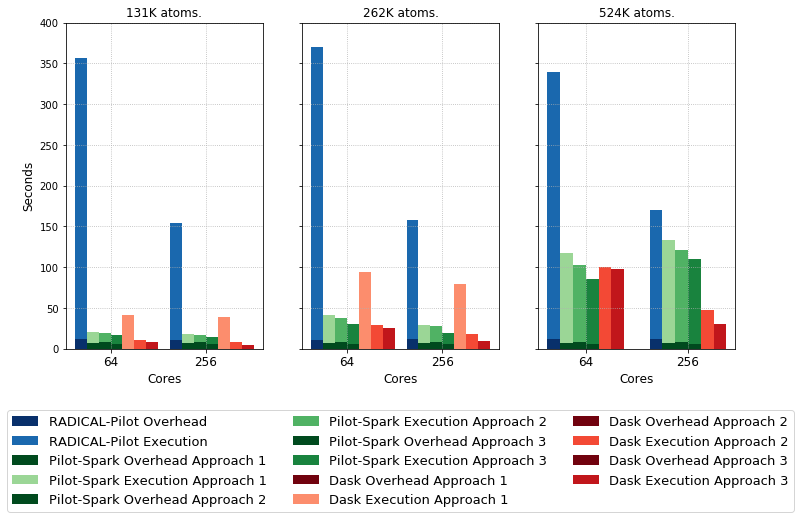

In [20]:
fig,axes = plt.subplots(nrows=1,ncols=3,sharey=True)
fig.set_size_inches(12,6)
width = 0.5
x = np.array([0,4])
axes[0].bar(x-2.5*width,RPmeansW[0:2]['RADICAL-Pilot Overhead'],log=0,width=width,color=blues(500),label='RADICAL-Pilot Overhead')
axes[0].bar(x-2.5*width,RPmeansW[0:2][['RADICAL-Pilot Edge Disc','RADICAL-Pilot DataMovement','RADICAL-Pilot ConnComp']].sum(axis=1),bottom=RPmeansW[0:2]['RADICAL-Pilot Overhead'],log=0,width=width,color=blues(200),label='RADICAL-Pilot Execution')

axes[1].bar(x-2.5*width,RPmeansW[2:4]['RADICAL-Pilot Overhead'],width=width,color=blues(500),label='RADICAL-Pilot Overhead')
axes[1].bar(x-2.5*width,RPmeansW[2:4][['RADICAL-Pilot Edge Disc','RADICAL-Pilot DataMovement','RADICAL-Pilot ConnComp']].sum(axis=1),bottom=RPmeansW[2:4]['RADICAL-Pilot Overhead'],width=width,color=blues(200),label='RADICAL-Pilot Execution')

axes[2].bar(x-2.5*width,RPmeansW[4:6]['RADICAL-Pilot Overhead'],width=width,color=blues(500),label='RADICAL-Pilot Overhead')
axes[2].bar(x-2.5*width,RPmeansW[4:6][['RADICAL-Pilot Edge Disc','RADICAL-Pilot DataMovement','RADICAL-Pilot ConnComp']].sum(axis=1),bottom=RPmeansW[4:6]['RADICAL-Pilot Overhead'],width=width,color=blues(200),label='RADICAL-Pilot Execution')

axes[0].bar(x-1.5*width,SpWraBroad131mean[0:2]['Pilot-Spark Overhead Approach 1'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 1')
axes[0].bar(x-1.5*width,SpWraBroad131mean[0:2][['Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1']].sum(axis=1),bottom=SpWraBroad131mean[0:2]['Pilot-Spark Overhead Approach 1'],width=width,color=greens(100),label='Pilot-Spark Execution Approach 1')

axes[1].bar(x-1.5*width,SpWraBroad262mean[0:2]['Pilot-Spark Overhead Approach 1'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 1')
axes[1].bar(x-1.5*width,SpWraBroad262mean[0:2][['Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1']].sum(axis=1),bottom=SpWraBroad131mean[0:2]['Pilot-Spark Overhead Approach 1'],width=width,color=greens(100),label='Pilot-Spark Execution Approach 1')

axes[2].bar(x-1.5*width,SpWraBroad524mean[0:2]['Pilot-Spark Overhead Approach 1'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 1')
axes[2].bar(x-1.5*width,SpWraBroad524mean[0:2][['Pilot-Spark Edge Disc Approach 1','Pilot-Spark ConnComp Approach 1']].sum(axis=1),bottom=SpWraBroad131mean[0:2]['Pilot-Spark Overhead Approach 1'],width=width,color=greens(100),label='Pilot-Spark Execution Approach 1')

axes[0].bar(x-0.5*width,SpWraColl131mean[0:2]['Pilot-Spark Overhead Approach 2'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 2')
axes[0].bar(x-0.5*width,SpWraColl131mean[0:2][['Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2']].sum(axis=1),bottom=SpWraColl131mean[0:2]['Pilot-Spark Overhead Approach 2'],width=width,color=greens(150),label='Pilot-Spark Execution Approach 2')

axes[1].bar(x-0.5*width,SpWraColl262mean[0:2]['Pilot-Spark Overhead Approach 2'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 2')
axes[1].bar(x-0.5*width,SpWraColl262mean[0:2][['Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2']].sum(axis=1),bottom=SpWraColl262mean[0:2]['Pilot-Spark Overhead Approach 2'],width=width,color=greens(150),label='Pilot-Spark Execution Approach 2')

axes[2].bar(x-0.5*width,SpWraColl524mean[0:2]['Pilot-Spark Overhead Approach 2'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 2')
axes[2].bar(x-0.5*width,SpWraColl524mean[0:2][['Pilot-Spark Edge Disc Approach 2','Pilot-Spark ConnComp Approach 2']].sum(axis=1),bottom=SpWraColl524mean[0:2]['Pilot-Spark Overhead Approach 2'],width=width,color=greens(150),label='Pilot-Spark Execution Approach 2')

axes[0].bar(x+0.5*width,SpWraPcc131mean[0:2]['Pilot-Spark Overhead Approach 3'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 3')
axes[0].bar(x+0.5*width,SpWraPcc131mean[0:2][['Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3']].sum(axis=1),bottom=SpWraPcc131mean[0:2]['Pilot-Spark Overhead Approach 3'],width=width,color=greens(200),label='Pilot-Spark Execution Approach 3')

axes[1].bar(x+0.5*width,SpWraPcc262mean[0:2]['Pilot-Spark Overhead Approach 3'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 3')
axes[1].bar(x+0.5*width,SpWraPcc262mean[0:2][['Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3']].sum(axis=1),bottom=SpWraPcc262mean[0:2]['Pilot-Spark Overhead Approach 3'],width=width,color=greens(200),label='Pilot-Spark Execution Approach 3')

axes[2].bar(x+0.5*width,SpWraPcc524mean[0:2]['Pilot-Spark Overhead Approach 3'],width=width,color=greens(250),label='Pilot-Spark Overhead Approach 3')
axes[2].bar(x+0.5*width,SpWraPcc524mean[0:2][['Pilot-Spark Execution Approach 3','Pilot-Spark Write Approach 3']].sum(axis=1),bottom=SpWraPcc524mean[0:2]['Pilot-Spark Overhead Approach 3'],width=width,color=greens(200),label='Pilot-Spark Execution Approach 3')

axes[0].bar(x+1.5*width,DaWraBroad131mean[0:2]['Dask Overhead Approach 1'],width=width,color=reds(250),label='Dask Overhead Approach 1')
axes[0].bar(x+1.5*width,DaWraBroad131mean[0:2][['Dask Edge Disc Approach 1','Dask ConnComp Approach 1']].sum(axis=1),bottom=DaWraBroad131mean[0:2]['Dask Overhead Approach 1'],width=width,color=reds(100),label='Dask Execution Approach 1')

axes[1].bar(x+1.5*width,DaWraBroad262mean[0:2]['Dask Overhead Approach 1'],width=width,color=reds(250),label='Dask Overhead Approach 1')
axes[1].bar(x+1.5*width,DaWraBroad262mean[0:2][['Dask Edge Disc Approach 1','Dask ConnComp Approach 1']].sum(axis=1),bottom=DaWraBroad262mean['Dask Overhead Approach 1'],width=width,color=reds(100),label='Dask Execution Approach 1')

axes[0].bar(x+2.5*width,DaWraColl131mean[0:2]['Dask Overhead Approach 2'],width=width,color=reds(250),label='Dask Overhead Approach 2')
axes[0].bar(x+2.5*width,DaWraColl131mean[0:2][['Dask Edge Disc Approach 2','Dask ConnComp Approach 2']].sum(axis=1),bottom=DaWraColl131mean[0:2]['Dask Overhead Approach 2'],width=width,color=reds(150),label='Dask Execution Approach 2')

axes[1].bar(x+2.5*width,DaWraColl262mean[0:2]['Dask Overhead Approach 2'],width=width,color=reds(250),label='Dask Overhead Approach 2')
axes[1].bar(x+2.5*width,DaWraColl262mean[0:2][['Dask Edge Disc Approach 2','Dask ConnComp Approach 2']].sum(axis=1),bottom=DaWraColl262mean[0:2]['Dask Overhead Approach 2'],width=width,color=reds(150),label='Dask Execution Approach 2')

axes[2].bar(x+1.5*width,DaWraColl524mean[0:2]['Dask Overhead Approach 2'],width=width,color=reds(250),label='Dask Overhead Approach 2')
axes[2].bar(x+1.5*width,DaWraColl524mean[0:2][['Dask Edge Disc Approach 2','Dask ConnComp Approach 2']].sum(axis=1),bottom=DaWraColl524mean[0:2]['Dask Overhead Approach 2'],width=width,color=reds(150),label='Dask Execution Approach 2')

axes[0].bar(x+3.5*width,DaWraParCC131mean[0:2]['Dask Overhead Approach 3'],width=width,color=reds(250),label='Dask Overhead Approach 3')
axes[0].bar(x+3.5*width,DaWraParCC131mean[0:2][['Dask Partial CC Approach 3','Dask Join CC Approach 3']].sum(axis=1),bottom=DaWraParCC131mean[0:2]['Dask Overhead Approach 3'],width=width,color=reds(200),label='Dask Execution Approach 3')

axes[1].bar(x+3.5*width,DaWraParCC262mean[0:2]['Dask Overhead Approach 3'],width=width,color=reds(250),label='Dask Overhead Approach 3')
axes[1].bar(x+3.5*width,DaWraParCC262mean[0:2][['Dask Partial CC Approach 3','Dask Join CC Approach 3']].sum(axis=1),bottom=DaWraParCC262mean[0:2]['Dask Overhead Approach 3'],width=width,color=reds(200),label='Dask Execution Approach 3')

axes[2].bar(x+2.5*width,DaWraParCC524mean[0:2]['Dask Overhead Approach 3'],width=width,color=reds(250),label='Dask Overhead Approach 3')
axes[2].bar(x+2.5*width,DaWraParCC524mean[0:2][['Dask Partial CC Approach 3','Dask Join CC Approach 3']].sum(axis=1),bottom=DaWraParCC524mean[0:2]['Dask Overhead Approach 3'],width=width,color=reds(200),label='Dask Execution Approach 3')

axes[0].set_xticks([0,4])
axes[0].set_xticklabels(['64','256'], fontsize=12)
axes[0].set_ylabel('Seconds', fontsize=12)
axes[0].set_title('131K atoms.', fontsize=12)
axes[0].set_xlabel('Cores',fontsize=12)
axes[0].grid('on',which='both',linestyle=':')

axes[1].set_xticks([0,4])
axes[1].set_xticklabels(['64','256'], fontsize=12)
axes[1].set_title('262K atoms.', fontsize=12)
axes[1].set_xlabel('Cores',fontsize=12)
axes[1].grid('on',which='both',linestyle=':')

axes[2].set_xticks([0,4])
axes[2].set_xticklabels(['64','256'], fontsize=12)
axes[2].set_title('524K atoms.', fontsize=12)
axes[2].set_xlabel('Cores',fontsize=12)
axes[2].grid('on',which='both',linestyle=':')
axes[0].set_xticks([0,4])
axes[0].set_xticklabels(['64','256'], fontsize=12)
axes[0].set_ylabel('Seconds', fontsize=12)
axes[0].set_title('131K atoms.', fontsize=12)
axes[0].set_xlabel('Cores',fontsize=12)
axes[2].grid('on',which='both',linestyle=':')
axes[0].set_ylim([0.1,400])
axes[1].legend(fontsize=13,bbox_to_anchor=(0., -0.5, 1., .102), loc='lower center',ncol=3, borderaxespad=0.)
#axes[0].set_yticks([0.1,1,10,100,500])
#axes[0].set_yticklabels(['0.1','1','10','100','300'])
#plt.savefig('WranglerLeafLetFinder.pdf',dpi=800,bbox_inches='tight')

# Further Analysis of RP 0.46 execution

## 131072 atoms

### Execution

In [21]:
singleCoreTimings = np.load('Vanilla/Wrangler/timings_131072.npz.npy')
singleCoreExecution = singleCoreTimings[:,-1] - singleCoreTimings[:,0]

concurrency = list()
unitDurationsStateModel = list()
unit_profs = pd.DataFrame(columns=['uid','after_cd','after_exec'])
for sid,session in sessions64.iteritems():
    if '131Kn' in sid:
        uid=list()
        for i in range(1,1025):
            uid.append('unit.%06d'%i)
            unit_profile = open('Vanilla/Wrangler/v0.46/'+sid+'/pilot.0000/unit.%06d/PROF'%i)
            unit_lines = unit_profile.readlines()
            for line in unit_lines:
                if 'after_cd' in line:
                    after_cd = float(line.split(',')[0])
                elif 'after_exec' in line:
                    after_exec = float(line.split(',')[0])
            unit_profs.loc[len(unit_profs)] = ['unit.%06d'%i,after_cd,after_exec]
            unit_profile.close()
        units = session.filter(uid=uid,etype='unit',inplace=False)
        concurrency.append(units.concurrency(state=[rp.AGENT_EXECUTING,rp.AGENT_STAGING_OUTPUT_PENDING]))
        for unit in units.get():
            dur = unit.duration(state=[rp.AGENT_EXECUTING,rp.AGENT_STAGING_OUTPUT_PENDING])
            unitDurationsStateModel.append(dur)
        
            
for sid,session in sessions256.iteritems():
    if '131Kn' in sid:
        uid=list()
        for i in range(1,1025):
            uid.append('unit.%06d'%i)
            unit_profile = open('Vanilla/Wrangler/v0.46/'+sid+'/pilot.0000/unit.%06d/PROF'%i)
            unit_lines = unit_profile.readlines()
            for line in unit_lines:
                if 'after_cd' in line:
                    after_cd = float(line.split(',')[0])
                elif 'after_exec' in line:
                    after_exec = float(line.split(',')[0])
            unit_profs.loc[len(unit_profs)] = ['unit.%06d'%i,after_cd,after_exec]
            unit_profile.close()
        units = session.filter(uid=uid,etype='unit',inplace=False)
        concurrency.append(units.concurrency(state=[rp.AGENT_EXECUTING,rp.AGENT_STAGING_OUTPUT_PENDING]))
        for unit in units.get():
            dur = unit.duration(state=[rp.AGENT_EXECUTING,rp.AGENT_STAGING_OUTPUT_PENDING])
            unitDurationsStateModel.append(dur)

unit_profs['time']=unit_profs['after_exec'] - unit_profs['after_cd']

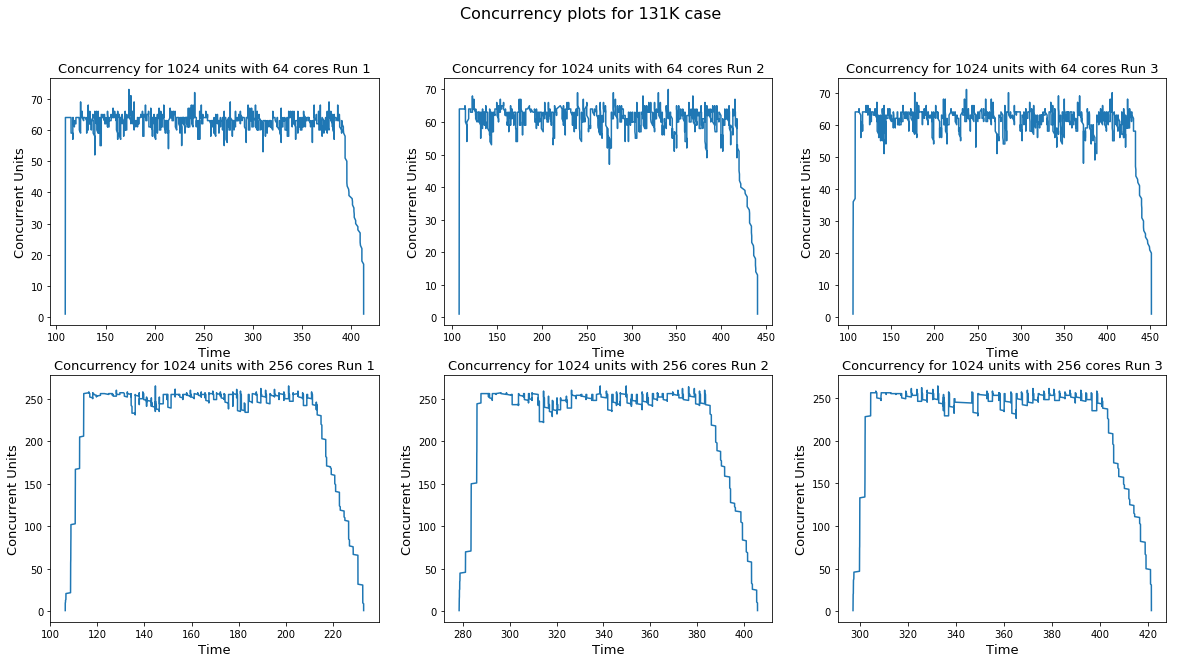

In [22]:
fig,axis = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(20,10)
fig.suptitle('Concurrency plots for 131K case',fontsize=16)

for i in range(6):
    
    conc = concurrency[i]
    x_axis = [point[0] for point in conc]
    y_axis = [point[1] for point in conc]

    axis[int(i>2),i%3].plot(x_axis,y_axis)
    axis[int(i>2),i%3].set_xlabel('Time',fontsize=13)
    axis[int(i>2),i%3].set_ylabel('Concurrent Units',fontsize=13)
    axis[int(i>2),i%3].set_title('Concurrency for 1024 units with %d cores Run %d'%((256 if i>2 else 64),(i%3)+1),fontsize=13)

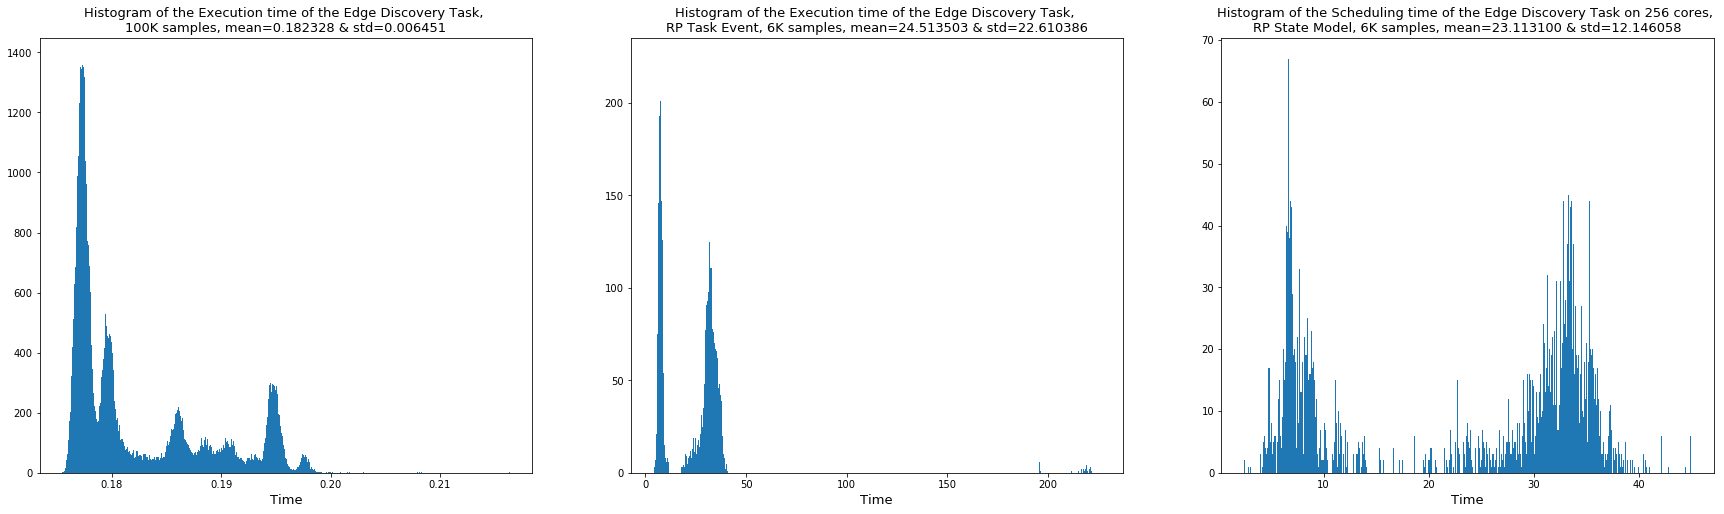

In [23]:
fig,axis=plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(30,8)

a = axis[0].hist(singleCoreExecution,bins=1000)
axis[0].set_xlabel('Time',fontsize=13)
axis[0].set_label('Number of samples')
axis[0].set_title('Histogram of the Execution time of the Edge Discovery Task, \n100K samples, mean=%f & std=%f'%(singleCoreExecution.mean(),singleCoreExecution.std()),fontsize=13)
axis[1].hist(unit_profs['time'],bins=1000)
axis[1].set_xlabel('Time',fontsize=13)
axis[1].set_label('Number of samples')
axis[1].set_title('Histogram of the Execution time of the Edge Discovery Task, \nRP Task Event, 6K samples, mean=%f & std=%f'%(unit_profs['time'].mean(),unit_profs['time'].std()),fontsize=13)
axis[2].hist(unitDurationsStateModel,bins=1000)
axis[2].set_xlabel('Time',fontsize=13)
axis[2].set_label('Number of samples')
axis[2].set_title('Histogram of the Scheduling time of the Edge Discovery Task on 256 cores, \nRP State Model, 6K samples, mean=%f & std=%f'%(np.mean(unitDurationsStateModel),np.std(unitDurationsStateModel)),fontsize=13)

## Scheduling

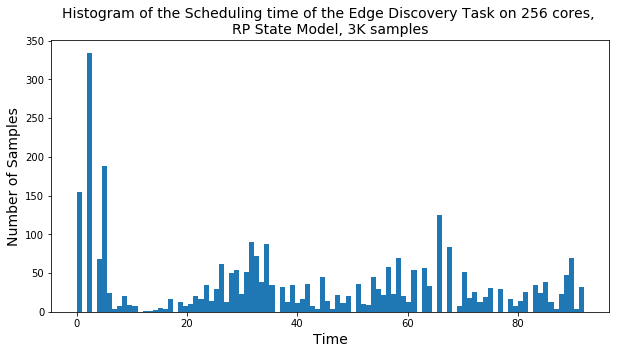

In [24]:
unitDurationsStateModel = list()

for sid,session in sessions256.iteritems():
    if '131Kn' in sid:
        uid=list()
        for i in range(1,1025):
            uid.append('unit.%06d'%i)
        units = session.filter(uid=uid,etype='unit',inplace=False)
        for unit in units.get():
            dur = unit.duration(state=[rp.AGENT_SCHEDULING,rp.AGENT_EXECUTING])
            unitDurationsStateModel.append(dur)
            
fig,axis = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10,5)

axis.hist(unitDurationsStateModel,bins=100)
axis.set_title('Histogram of the Scheduling time of the Edge Discovery Task on 256 cores, \nRP State Model, 3K samples',fontsize=14)
axis.set_ylabel('Number of Samples',fontsize=14)
axis.set_xlabel('Time',fontsize=14)

# Time until the unit reaches the Scheduler

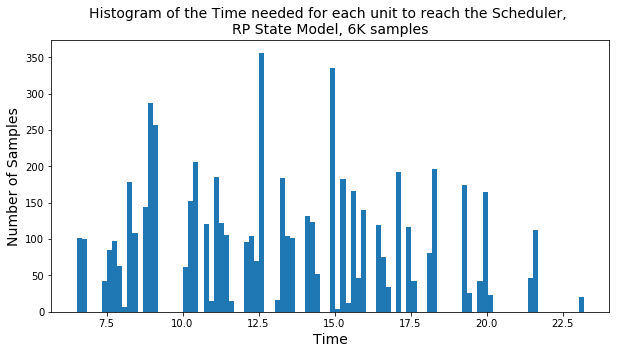

In [25]:
unitDurationsStateModel = list()
for sid,session in sessions64.iteritems():
    if '131Kn' in sid:
        uid=list()
        for i in range(1,1025):
            uid.append('unit.%06d'%i)
        units = session.filter(uid=uid,etype='unit',inplace=False)
        for unit in units.get():
            dur = unit.duration(state=[rp.UMGR_SCHEDULING_PENDING,rp.AGENT_SCHEDULING])
            unitDurationsStateModel.append(dur)
            
for sid,session in sessions256.iteritems():
    if '131Kn' in sid:
        uid=list()
        for i in range(1,1025):
            uid.append('unit.%06d'%i)
        units = session.filter(uid=uid,etype='unit',inplace=False)
        for unit in units.get():
            dur = unit.duration(state=[rp.UMGR_SCHEDULING_PENDING,rp.AGENT_SCHEDULING])
            unitDurationsStateModel.append(dur)
            
fig,axis = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10,5)

axis.hist(unitDurationsStateModel,bins=100)
axis.set_title('Histogram of the Time needed for each unit to reach the Scheduler, \nRP State Model, 6K samples',fontsize=14)
axis.set_ylabel('Number of Samples',fontsize=14)
axis.set_xlabel('Time',fontsize=14)

### Time from finishing execution until Done

In [26]:
unitDurationsStateModel = list()
for sid,session in sessions64.iteritems():
    if '131Kn' in sid:
        uid=list()
        for i in range(1,1025):
            uid.append('unit.%06d'%i)
        units = session.filter(uid=uid,etype='unit',inplace=False)
        for unit in units.get():
            dur = unit.duration(state=[rp.AGENT_STAGING_OUTPUT_PENDING,rp.DONE])
            unitDurationsStateModel.append(dur)
            
for sid,session in sessions256.iteritems():
    if '131Kn' in sid:
        uid=list()
        for i in range(1,1025):
            uid.append('unit.%06d'%i)
        units = session.filter(uid=uid,etype='unit',inplace=False)
        for unit in units.get():
            dur = unit.duration(state=[rp.AGENT_STAGING_OUTPUT_PENDING,rp.DONE])
            unitDurationsStateModel.append(dur)
            
fig,axis = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(10,5)

axis.hist(unitDurationsStateModel,bins=100)
axis.set_title('Histogram of the Time needed for each unit to be reported as Done after executing, \nRP State Model, 6K samples',fontsize=14)
axis.set_ylabel('Number of Samples',fontsize=14)
axis.set_xlabel('Time',fontsize=14)

ValueError: duration uncovered time inconsistency

## 262144

### Execution